In [1]:
from transformers import pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import utils # all data reading and preprocessing functionality
from textwrap import wrap

In [2]:
featurizer = pipeline('feature-extraction')

No model was supplied, defaulted to distilbert-base-cased (https://huggingface.co/distilbert-base-cased)
Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
file1 = './data/abstract_set1.txt'
file2 = './data/abstract_set2.txt'
data_selection = 'abstract'
label_selection = 'label' # can be 'label' or 'text_label'

In [17]:
#df = utils.read_abstract_data(negatives_path=file2, positives_path=file1)
df = pd.read_csv(file1, sep='\t') # only the pesticide papers
df = df.dropna()
df.reset_index(drop=True, inplace=True)
df.head()

,pmid,title,abstract
0,29990300,Oxidative stress in triazine pesticide toxicit...,This review article provides a summary of the ...
1,29990732,Toxicity induced by glyphosate and glyphosate-...,Glyphosate is the active component of many com...
2,29999060,Direct kinetics study of CH2OO + methyl vinyl ...,Methyl vinyl ketone (MVK) and methacrolein (MA...
3,30003825,Dihydromyricetin improves vascular hyporespons...,CONTEXT: Dihydromyricetin (DMY) has oxidation ...
4,30015122,Glyphosate and atrazine in rainfall and soils ...,The presence in the atmosphere of glyphosate (...


In [18]:
df.shape

(4692, 3)

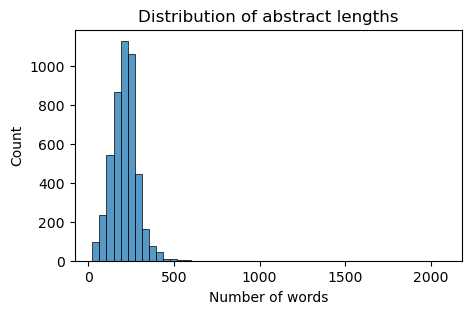

In [19]:
# get a picture of the lengths distribution of the abstracts

lens = [len(a.split()) for a in df.abstract]
# same: df['abstract'].str.split().str.len()
import seaborn as sns
plt.figure(figsize=(5, 3))
sns.histplot(lens, bins=50)
plt.title('Distribution of abstract lengths')
plt.xlabel('Number of words')
plt.ylabel('Count')
#plt.savefig('./figures/abstract_lengths.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
np.max(lens)

2080

In [7]:
# sample 1000 rows -- otherwise it takes too long
#df = df.sample(n=500, random_state=1)
#df = df.reset_index(drop=True)

#simply select first N rows -- takes only from the pesticide papers
#df = df.iloc[:2000]

In [8]:
# this fails because of sequence length (in particular, the number of tokens generated from the input document)
# which can not exceed 512 tokens)

#result = featurizer(df.iloc[0, 2])

In [20]:
MAX_TOKENS = 80
# get the values as list of strings
texts = df.iloc[:,2].astype(str).tolist()
# truncate to 350 words was not sufficient
# tried many different sizes; ended up with extremely low value for truncation;
# this is probably because of the strange nature of scientific paper abstracts
# maybe we need another pretrained model for this type of text.
# Also, the complexity increase of the calculations is quadratic
texts = [' '.join(x.split()[:MAX_TOKENS]) for x in texts] # in the course, this was set to 100

[len(x.split()) for x in texts[:10]] # check the length of each entry

[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]

In [21]:
test = featurizer(texts[0])

In [22]:
# simply printing will give a 3D list
# test
len(test)

1

In [23]:
print(type(test[0]))
print(type(test[0][0]))

<class 'list'>
<class 'list'>


In [24]:
test_np = np.array(test)
test_np.shape # N x T x D
# N = number of sentences (only one here)
# T = number of tokens
# D = embedding dimension (768) -- this will be the same for all documents

(1, 126, 768)

In [ ]:
# On my laptop (no GPU) this takes a very long time (> 20 mins) on the whole set
# and even at a cutoff of 100 words, it crashes on the whole set of 5,000 (and 10,000 papers - this is including "control" papers)
embeddings = featurizer(texts)
# tried this on whole set at 100 tokens: failed
# tried this at 100 words with 2000 papers: this succeeded
# tried again on whole set (only pesticides) at 90 tokens: failed
# tried again on whole set (only pesticides) at 80 tokens: succeeds (in just under 11 minutes)

In [26]:
len(embeddings)

4692

In [27]:
# list of length N, each element is 1 x T x D, but T is variable
# we only want to keep the first embedding vector
# (not like RNNs, where you typically take the last hidden state vector)
# every T position can pay "attention" to all of the T inputs
# we can take the mean of all T vectors, or just the first one

# embeddings = [np.array(e[0]).mean(axis=0) for e in embeddings] # average
embeddings = [e[0][0] for e in embeddings] # first is convention
# now you have N vectors of size D: 

In [28]:
embeddings = np.array(embeddings)
embeddings.shape # N x D

(4692, 768)

Now we have a type of data that supports nearest neighbour search.

In [89]:
model = NearestNeighbors(metric='cosine', n_neighbors=8)
model.fit(embeddings)

NearestNeighbors(metric='cosine', n_neighbors=8)

In [90]:
distances, indices = model.kneighbors(embeddings[1].reshape(1, -1))
# reshaping is necessary because the input to sklearn kneighbors has to be 2D: 1 x D (N x D more generally)
# the -1 is a wildcard (will be calculated automatically - to 768)

In [91]:
distances, indices

(array([[0.        , 0.00374154, 0.00414541, 0.00458775, 0.00461752,
         0.00473688, 0.00474542, 0.00476646]]),
 array([[   1, 2981, 4666, 2895, 3223,  427, 3444,   45]]))

In [92]:
for df_index in indices[0]:
    print(df_index)
    utils.print_paper(df.iloc[df_index].pmid, df)
    print('\n')
    print('---')
    print('\n')

1
PubMed ID: 29990732

Title: 
Toxicity induced by glyphosate and glyphosate-based herbicides in the zebrafish
hepatocyte cell line (ZF-L).

Abstract:
Glyphosate is the active component of many commonly used herbicides; it can
reach bodies of water through irrigated rice plantations. In the present study,
we evaluated the effect of glyphosate and Roundup® (a glyphosate-based
herbicide) in established culture of the zebrafish hepatocyte cell line ZF-L
after 24 and 48 h of exposure to concentrations of 650 and 3250 µg/L. We
observed a reduction in metabolic activity and lysosomal integrity, and an
increase in cell number after 24 h of Roundup® exposure at the highest
concentration. An increase in active mitochondria and apoptotic cells was
observed following 24 h exposure to glyphosate and Roundup®, while only exposure
to Roundup® induced an increase in necrotic cells. Rhodamine B accumulation
decreased after 48 h exposure to 650 µg/L of Roundup®; this reduction is
indicative of increase

A simple abstract query question

In [93]:
query = featurizer("glyphosate toxicity in insects")

In [94]:
print(len(query)) # N
print(len(query[0])) # T
print(len(query[0][0])) # D

1
10
768


In [95]:
distances, indices = model.kneighbors(np.array(query[0][0]).reshape(1, -1))
distances, indices

(array([[0.01549575, 0.01553211, 0.0156776 , 0.01625035, 0.01731194,
         0.01733211, 0.0174149 , 0.0174652 ]]),
 array([[3435, 3256, 4007, 1921, 2911, 2825, 1739, 2134]]))

In [96]:
for df_index in indices[0][:3]:
    print(df_index)
    utils.print_paper(df.iloc[df_index].pmid, df)
    print('\n')
    print('---')
    print('\n')

3435
PubMed ID: 31676883

Title: 
Identification of candidate ATP-binding cassette transporter gene family members
in Diaphorina citri (Hemiptera: Psyllidae) via adult tissues transcriptome
analysis.

Abstract:
The ATP-binding cassette (ABC) transporters exist in all living organisms and
play major roles in various biological functions by transporting a wide variety
of substrates across membranes. The functions of ABC transporters in drug
resistance have been extensively studied in vertebrates; however, they are
rarely characterized in agricultural pests. The Asian citrus psyllid, Diaphorina
citri, is one of the most damaging pests of the Citrus genus because of its
transmission of Huanglongbing, also known as Yellow Dragon disease. In this
study, the next-generation sequencing technique was applied to research the ABC
transporters of D. citri. Fifty-three ABC transporter genes were found in the
RNA-Seq data, and among these ABC transporters, 4, 4, 5, 2, 1, 4, 18 and 15 ABC
proteins be

Now for a completely unseen example

In [97]:
query_text = "Uncontrolled use of pesticides has caused a dramatic reduction in the number of pollinators, including bees. Studies on the effects of pesticides on bees have reported effects on both metabolic and neurological levels under chronic exposure. In this study, variations in the differential expression of head and thorax-abdomen proteins in Africanized A. mellifera bees treated acutely with sublethal doses of glyphosate and imidacloprid were studied using a proteomic approach. A total of 92 proteins were detected, 49 of which were differentially expressed compared to those in the control group (47 downregulated and 2 upregulated). Protein interaction networks with differential protein expression ratios suggested that acute exposure of A. mellifera to sublethal doses of glyphosate could cause head damage, which is mainly associated with behavior and metabolism. Simultaneously, imidacloprid can cause damage associated with metabolism as well as, neuronal damage, cellular stress, and impairment of the detoxification system. Regarding the thorax-abdomen fractions, glyphosate could lead to cytoskeleton reorganization and a reduction in defense mechanisms, whereas imidacloprid could affect the coordination and impairment of the oxidative stress response."
query_text = ' '.join(query_text.split()[:MAX_TOKENS])
query = featurizer(query_text)

In [98]:
np.array(query).shape # 1 x T x D

(1, 121, 768)

In [99]:
distances, indices = model.kneighbors(np.array(query[0][0]).reshape(1, -1))
distances, indices

(array([[0.00449621, 0.00489968, 0.00506949, 0.00510148, 0.0053735 ,
         0.00545237, 0.00563506, 0.00581696]]),
 array([[4662, 3803, 3957, 3100, 4573, 4565, 3997, 3304]]))

In [100]:

for df_index in indices[0][:3]:
    print(df_index)
    utils.print_paper(df.iloc[df_index].pmid, df)
    print('\n')
    print('---')
    print('\n')

4662
PubMed ID: 39277411

Title: 
Interactive effects of chlorothalonil and Varroa destructor on Apis mellifera
during adult stage.

Abstract:
The interaction between environmental factors affecting honey bees is of growing
concern due to their potential synergistic effects on bee health. Our study
investigated the interactive impact of Varroa destructor and chlorothalonil on
workers' survival, fat body morphology, and the expression of gene associated
with detoxification, immunity, and nutrition metabolism during their adult
stage. We found that both chlorothalonil and V. destructor significantly
decreased workers' survival rates, with a synergistic effect observed when bees
were exposed to both stressors simultaneously. Morphological analysis of fat
body revealed significant alterations in trophocytes, particularly a reduction
in vacuoles and granules after Day 12, coinciding with the transition of the
bees from nursing to other in-hive work tasks. Gene expression analysis showed
sig